# DATASCI W261: Machine Learning at Scale 

* **Sayantan/Juanjose/Chris**
* **W261**
* **Week-9**
* **Assignment-9**
* **Date of Submission: 04-NOV-2015**

#  === Week 9: Page Rank ===

### First BASE Version [Before HW9 was published]

In [163]:
%%writefile mrjob_hw90.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol
from mrjob.compat import get_jobconf_value
import sys
import ast

'''
Sample Input Data:
1	0.2,[2,4]
2	0.2,[3,5]
3	0.2,[4]
4	0.2,[5]
5	0.2,[1,2,3]
'''

class PageRankFirstVersion(MRJob):
    
    INPUT_PROTOCOL = RawProtocol
    
    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                  reducer=self.reducer)
        ]
    

    def mapper(self, key, value):
        value = value.strip().replace("\"","")
        t = value.split("|")
        
        #sys.stderr.write('[M] {0} | {1} | {2}\n'.format(key, t[0], t[1]))
        
        node = key
        score = t[0]
        neighbors = ast.literal_eval(t[1])
        
        # Emit the Graph Structure
        yield int(node), ('NODE', value)
        
        # Emit the mass
        for n in neighbors:
            yield n, ('SCORE', float(score)/len(neighbors))
                   
        #self.increment_counter('page_rank', 'dangling_node', amount=1)
            
    def combiner(self, key, values):
        pass

        
    def reducer(self, key, values):
        prev_score = None
        adj_list = None
        total_score = 0

        for value_type, value in values:
            #sys.stderr.write('[R1] {0} | {1} | {2}\n'.format(key, value_type, value))
            if value_type == 'NODE':
                t = value.strip().split("|")
                prev_score = t[0]
                adj_list = t[1]
            else:
                assert value_type == 'SCORE'
                total_score += value
        
        '''
        node['prev_score'] = node['score']

        d = self.options.damping_factor
        node['score'] = 1 - d + d * total_score
        '''

        #sys.stderr.write('[R2] {0} | {1} | {2}\n\n'.format(key, total_score, adj_list))
        yield key, '{0}|{1}'.format(total_score, adj_list)

   
if __name__ == '__main__':
    PageRankFirstVersion.run()

Overwriting mrjob_hw90.py


In [164]:
!chmod a+x mrjob_hw90.py

In [165]:
# Run Once
!python mrjob_hw90.py pr.txt

using configs in /Users/ssatpati/.mrjob.conf
creating tmp directory /var/folders/h5/1q71m1c54cn07f16c232pqgm38ynd8/T/mrjob_hw90.ssatpati.20151101.165710.431202

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to /var/folders/h5/1q71m1c54cn07f16c232pqgm38ynd8/T/mrjob_hw90.ssatpati.20151101.165710.431202/step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to /var/folders/h5/1q71m1c54cn07f16c232pqgm38ynd8/T/mrjob_hw90.ssatpati.20151101.165710.431202/step-0-mapper-sorted
> sort /var/folders/h5/1q71m1c54cn07f16c232pqgm38ynd8/T/mrjob_hw90.ssatpati.20151101.165710.431202/step-0-mapper_part-00000
writing to /var/folders/h5/1q71m1c54cn07f16c232pqgm38ynd8/T/mrjob_hw90.ssatpati.20151101.165710.431202/step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
M

In [167]:
%reload_ext autoreload
%autoreload 2
from mrjob_hw90 import PageRankFirstVersion
import pprint

input_file = 'pr.txt'
input_file_iter = input_file + '1'

cnt = 0

# After so many iterations (TBD: Convergence Criteria)
while cnt < 5:
    print "\n\nIteration: " + str(cnt+1) + ":"
    if cnt == 0:
        mr_job = PageRankFirstVersion(args=[input_file,
                                '--no-strict-protocol'])
    else:
        mr_job = PageRankFirstVersion(args=[input_file_iter,
                                '--no-strict-protocol'])

    with mr_job.make_runner() as runner: 
        runner.run()

        with open(input_file_iter, 'w') as f:
            for line in runner.stream_output():
                parsed_line = mr_job.parse_output_line(line)
                print parsed_line
                f.write(line)
                
    cnt += 1

    #print "# MR Counters:"
    #pprint.pprint(runner.counters()[0])



Iteration: 1:
(1, '0.0666666666667|[2,4]')
(2, '0.166666666667|[3,5]')
(3, '0.166666666667|[4]')
(4, '0.3|[5]')
(5, '0.3|[1,2,3]')


Iteration: 2:
(1, '0.1|[2,4]')
(2, '0.133333333333|[3,5]')
(3, '0.183333333333|[4]')
(4, '0.2|[5]')
(5, '0.383333333334|[1,2,3]')


Iteration: 3:
(1, '0.127777777778|[2,4]')
(2, '0.177777777778|[3,5]')
(3, '0.194444444444|[4]')
(4, '0.233333333333|[5]')
(5, '0.266666666667|[1,2,3]')


Iteration: 4:
(1, '0.088888888889|[2,4]')
(2, '0.152777777778|[3,5]')
(3, '0.177777777778|[4]')
(4, '0.258333333333|[5]')
(5, '0.322222222222|[1,2,3]')


Iteration: 5:
(1, '0.107407407407|[2,4]')
(2, '0.151851851852|[3,5]')
(3, '0.183796296296|[4]')
(4, '0.222222222222|[5]')
(5, '0.334722222222|[1,2,3]')


## HW9.0
____

***===HW 9.0: Short answer questions===***

What is PageRank and what is it used for in the context of web search?
What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to 
compute the steady stade distibuton?
OPTIONAL: In topic-specific pagerank, how can we insure that the irreducible property is satified? (HINT: see HW9.4)

PageRank is an algorithm for computing a ranking for every web page based on the graph of the web. It uses (apart from the structure of that graph) the forward links and backlinks connecting the web pages, and has applications in search, browsing, traffic estimation, etc.

In order to compute the steady state distribution of the Markov chain that is the random surfer in which PageRank is based, the matrix that represents the random surfer must be stochastic. To have such a matrix, we must ensure that the random surfer does not get stuck at a dangling node, by adding a teleportation factor to all probabilities in the matrix (α/N, where N is the number of nodes in the web graph) such that the random surfer will jump to any node, with uniform probability. A second modification is that we have to distribute the probability mass (m) of all dangling nodes at a certain state to all the nodes in the graph; this is done by substituting all cells in a column of the transition matrix corresponding to a dangling node (i.e., a node with no forward links), which would be zero, by 1/N.

By removing all columns of the transition matrix M and all elements of the teleportation vector p that correspond to nodes not reachable from nodes of a certain topic (i.e., nonzero nodes in p). In topic-specific PageRank, teleportation probabilities are not uniform: for a given topic, only nodes corresponding to that topic get a nonzero teleportation probability (1/x, with x the number of nodes in that category), and the rest will have a zero teleportation probability.

## HW 7.5.1
___

***Addendum questions from HW7***
=== HW 7.5.1: 

Can we utilize combiners in the HW 7 to perform the shortest path implementation?

Does order inversion help with the HW 7 shortest path implementation?

Yes, we could use combiners. Say we have the following graph:

```
 A {B: 1, E: 10}
 B {C:1}
 C {D:1, F: 2}
 D {E:3}
 F {E: 1}
```

In the 1st iteration the distance from A to E is set to 10. In the 4th iteration, the mapper emits both (E, 6) (A-B-C-D-E) and (E, 5) (A-B-C-F-E). A combiner would take both outputs from the mapper and discards the former, passing to the reducer only the latter, and hence reducing network traffic.

This answer is based on the implementation of the shortest path for weighted links, the one that we used in HW7; if the graph is unweighted, a combiner would add no value.

Another apporach would be with a code quite similar to those in the reducers. I.e., they would update the SSSP and the Frontiers "in advance"(N.B.: this answer is based .

No (at least in the weighted graph version), since there is no general information about a node that must be used first.

## HW 9.1
---

MRJob implementation of basic PageRank

Write a basic MRJob implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input (as explored in HW 7).
Make sure that you implementation utilizes teleportation (damping),
and further, distributes the mass of dangling nodes with each iteration
so that the output of each iteration is correctly normalized (sums to 1).


As you build your code, use the test data

s3://ucb-mids-mls-networks/PageRank-test.txt

with teleportation parameter set to 0.15, and crosscheck
your work with the true result, displayed in the first image
in the Wikipedia article:

https://en.wikipedia.org/wiki/PageRank

and here for reference are the corresponding PageRank probabilities:


```
A,0.033
B,0.384
C,0.343
D,0.039
E,0.081
F,0.039
G,0.016
H,0.016
I,0.016
J,0.016
K,0.016
```

In [121]:
%%writefile mrjob_preproc_hw91.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol
from mrjob.compat import get_jobconf_value
import sys
import ast


class FilePreProc(MRJob):
        
    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                  reducer=self.reducer)
        ]
    

    def mapper(self, _, line):
        t = line.strip().split('\t')
        adj_list = ast.literal_eval(t[1])
        
        yield t[0], adj_list
        
        for n in adj_list:
            yield n, '*'
          
    def reducer(self, key, values):  
        source = False
        adj_list = {}
        for v in values:
            if type(v) == type({}):
                source = True
                adj_list = v
        yield key, adj_list
   
if __name__ == '__main__':
    FilePreProc.run()

Overwriting mrjob_preproc_hw91.py


In [122]:
!chmod a+x mrjob_preproc_hw91.py

In [123]:
!python mrjob_preproc_hw91.py PageRank-test.txt > PageRank-test.txt.pp

using configs in /Users/ssatpati/.mrjob.conf
creating tmp directory /var/folders/h5/1q71m1c54cn07f16c232pqgm38ynd8/T/mrjob_preproc_hw91.ssatpati.20151101.215010.833223

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to /var/folders/h5/1q71m1c54cn07f16c232pqgm38ynd8/T/mrjob_preproc_hw91.ssatpati.20151101.215010.833223/step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to /var/folders/h5/1q71m1c54cn07f16c232pqgm38ynd8/T/mrjob_preproc_hw91.ssatpati.20151101.215010.833223/step-0-mapper-sorted
> sort /var/folders/h5/1q71m1c54cn07f16c232pqgm38ynd8/T/mrjob_preproc_hw91.ssatpati.20151101.215010.833223/step-0-mapper_part-00000
writing to /var/folders/h5/1q71m1c54cn07f16c232pqgm38ynd8/T/mrjob_preproc_hw91.ssatpati.20151101.215010.833223/step-0-reducer_part-00000
Count

In [203]:
%%writefile mrjob_hw91.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol
from mrjob.compat import get_jobconf_value
import sys
import ast
from numpy import log1p, exp, log

## A function to sum log probabilities
def sum_log(p, q):
    if q > p:
        b = log(q)
        if p == 0:
            return exp(b + log1p(0))
        else:
            a = log(p)
            return exp(b + log1p(exp(a-b)))
    else:
        if q == 0:
            if p == 0:
                return 0.
            else:
                a = log(p)
                return exp(a + log1p(0))
        else:
            b = log(q)
            a = log(p)
            return exp(a + log1p(exp(b-a)))


class PageRank(MRJob):
    
    INPUT_PROTOCOL = RawProtocol
    
    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                  reducer=self.reducer),
            MRStep(mapper_init=self.mapper_dangling_init,
                mapper=self.mapper_dangling)
        ]
    

    def mapper(self, key, value):
        nodes = int(get_jobconf_value('nodes'))
        i = int(get_jobconf_value('iteration'))
        #sys.stderr.write('[M] {0}, {1} \n'.format(key, value))
        key = key.replace("\"","")
        key = key.replace("\\","")
        adj_list = ast.literal_eval(value)
      
        score = 0
        l = 0
        
        if 'score' in adj_list.keys():
            # Previous Mass/Page Rank
            score = adj_list['score']
            l = len(adj_list) - 1
        else: # First iteration ('score' not yet part of the adjacency list!)
            # Start with uniform probability distribution
            score = 1.0 / nodes
            l = len(adj_list)
            adj_list['score'] = score
            
        if l == 0: # Only 'score' & no out links [Dangling!]
            sys.stderr.write('[{0}][M] "DANGLING MASS" | {1} | {2}\n'.format(i, key, score))
            # Emit using a special key; Accumlate in Reducer;Distribute in the next MRJob
            yield 'DANGLING', ('SCORE', score)
       
        # Emit the Graph Structure
        yield key, ('GRAPH', adj_list)
                    
        # Emit the new Mass/Page Rank
        for n in adj_list:
            if n != 'score':
                yield n, ('SCORE', score/l)
                               
    def combiner(self, key, values):
        pass

        
    def reducer(self, key, values):     
        i = int(get_jobconf_value('iteration'))
        teleportation = float(get_jobconf_value('teleportation'))
        nodes = int(get_jobconf_value('nodes'))
        
        adj_list = None
        total_score = 0

        for value_type, value in values:
            if value_type == 'GRAPH':
                adj_list = value
            else:
                assert value_type == 'SCORE'
                total_score += value
                #total_score = sum_log(total_score, value)
                
        # Special Key
        if key == 'DANGLING':
            # Write accumulated Dangling Score in a file
            with open('/Users/ssatpati/0-DATASCIENCE/DEV/github/ml/w261/wk9/dangling.txt', 'w') as f:
                f.write('DANGLING\t{0}\n'.format(total_score))
        else:
            #total_score = (teleportation / nodes) + ((1 - teleportation) * total_score)
            #total_score = sum_log((teleportation / nodes), ((1 - teleportation) * total_score))
            if adj_list:
                adj_list['score'] = total_score
            else:
                adj_list = {'score': total_score}
    
            #sys.stderr.write('[R2] {0} | {1} | {2}\n\n'.format(key, total_score, adj_list))
            yield key, adj_list
       

    def mapper_dangling_init(self):
        i = int(get_jobconf_value('iteration'))
        self.dangling_mass = 0
        f_dangling = '/Users/ssatpati/0-DATASCIENCE/DEV/github/ml/w261/wk9/dangling.txt'
        try:
            with open(f_dangling, 'r') as f:
                l = f.readlines()
                if l:
                    self.dangling_mass = float(l[0].split('\t')[1])
            open(f_dangling, 'w').close()
        except Exception as e:
            pass
        sys.stderr.write('[{0}][M_D] DANGLING MASS: {1}\n'.format(i, self.dangling_mass))
        
    def mapper_dangling(self, key, value):
        #sys.stderr.write('[M_D] {0}, {1} \n'.format(key, value))
        i = int(get_jobconf_value('iteration'))
        key = key.replace("\"","")
        key = key.replace("\\","")
        adj_list = ast.literal_eval(str(value))
        
        if self.dangling_mass > 0:
            nodes = int(get_jobconf_value('nodes'))
            teleportation = float(get_jobconf_value('teleportation'))
            score = adj_list['score']
            modified_score = (teleportation / nodes) + (1 - teleportation) * ((self.dangling_mass / nodes) + score)
            #modified_score = sum_log((teleportation / nodes), (1 - teleportation)*(self.dangling_mass / nodes))
            #modified_score = sum_log(modified_score, (1 - teleportation)*score)
            adj_list['score'] = modified_score
            
        yield key, adj_list
        

   
if __name__ == '__main__':
    PageRank.run()

Overwriting mrjob_hw91.py


In [204]:
!chmod a+x mrjob_hw91.py

In [209]:
%reload_ext autoreload
%autoreload 2
from mrjob_hw91 import PageRank
import ast
import pprint

input_file = 'PageRank-test.txt.pp'
input_file_iter = input_file + '1'

cnt = 0
MAX_ITERATIONS = 100
NODES = 11
TELEPORTATION = 0.15

prev_ranks = []
curr_ranks = []
sum_partial_diff_PR = float('inf')

# After so many iterations (TBD: Convergence Criteria)
while sum_partial_diff_PR > .0005:
    print "\n\nIteration: " + str(cnt+1) + ":"
    if cnt == 0:
        mr_job = PageRank(args=[input_file,
                                '--jobconf', 'teleportation={0}'.format(TELEPORTATION),
                                '--jobconf', 'nodes={0}'.format(NODES),
                                '--jobconf', 'iteration={0}'.format(cnt+1),
                                '--no-strict-protocol'])
    else:
        mr_job = PageRank(args=[input_file_iter,
                                '--jobconf', 'teleportation={0}'.format(TELEPORTATION),
                                '--jobconf', 'nodes={0}'.format(NODES),
                                '--jobconf', 'iteration={0}'.format(cnt+1),
                                '--no-strict-protocol'])

    with mr_job.make_runner() as runner: 
        runner.run()
        
        if cnt == 0:
            prev_ranks = [0 in xrange(NODES)]
        else:
            prev_ranks = curr_ranks[:]
            del curr_ranks[:]
        
        total_page_rank = 0
        ranks = []
        with open(input_file_iter, 'w') as f:
            for line in runner.stream_output():
                parsed_line = mr_job.parse_output_line(line)
                
                print parsed_line
                neigbors = ast.literal_eval(str(parsed_line[1]))
                total_page_rank += float(neigbors['score'])
                
                curr_ranks.append(round(neigbors['score'], 3))
                
                f.write(line)
                        
        sum_partial_diff_PR = sum([abs(x-y) for x,y in zip(curr_ranks, prev_ranks)])
        
        print "\n#Iteration: {0}, Page Rank (Sum): {1}".format(cnt + 1, total_page_rank)
        print "#Iteration: {0}, Difference in Ranks: {1}".format(cnt + 1, sum_partial_diff_PR)
        print 'Prev Page Ranks: ', prev_ranks
        print 'Curr Page Ranks: ', curr_ranks
                                
    cnt += 1
    

[1][M] "DANGLING MASS" | A | 0.0909090909091
[1][M_D] DANGLING MASS: 0.0909090909091
[2][M] "DANGLING MASS" | A | 0.0592975206612
[2][M_D] DANGLING MASS: 0.0592975206612




Iteration: 1:
('A', {'score': 0.059297520661157725})
('B', {'C': 1, 'score': 0.3168732782369153})
('C', {'B': 1, 'score': 0.09793388429752137})
('D', {'A': 1, 'B': 1, 'score': 0.04641873278236985})
('E', {'F': 1, 'B': 1, 'score': 0.3297520661157031, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.04641873278236985})
('G', {'B': 1, 'E': 1, 'score': 0.02066115702479409})
('H', {'B': 1, 'E': 1, 'score': 0.02066115702479409})
('I', {'B': 1, 'E': 1, 'score': 0.02066115702479409})
('J', {'score': 0.02066115702479409, 'E': 1})
('K', {'score': 0.02066115702479409, 'E': 1})

#Iteration: 1, Page Rank (Sum): 1.0
#Iteration: 1, Difference in Ranks: 0.941
Prev Page Ranks:  [True]
Curr Page Ranks:  [0.059, 0.317, 0.098, 0.046, 0.33, 0.046, 0.021, 0.021, 0.021, 0.021, 0.021]


Iteration: 2:
('A', {'score': 0.03794640621087264})
('B', {'C': 1, 'score': 0.26069089656900135})
('C', {'B': 1, 'score': 0.2875607312797434})
('D', {'A': 1, 'B': 1, 'score': 0.11164819684448135})
('E', {'F': 1, 'B': 1, 'score': 0

[3][M] "DANGLING MASS" | A | 0.0379464062109
[3][M_D] DANGLING MASS: 0.0379464062109
[4][M] "DANGLING MASS" | A | 0.0640190695934



('B', {'C': 1, 'score': 0.40729180730104886})
('C', {'B': 1, 'score': 0.23815584801812978})
('D', {'A': 1, 'B': 1, 'score': 0.0447357013030419})
('E', {'F': 1, 'B': 1, 'score': 0.11821894280902044, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.0447357013030419})
('G', {'B': 1, 'E': 1, 'score': 0.016568585934478637})
('H', {'B': 1, 'E': 1, 'score': 0.016568585934478637})
('I', {'B': 1, 'E': 1, 'score': 0.016568585934478637})
('J', {'score': 0.016568585934478637, 'E': 1})
('K', {'score': 0.016568585934478637, 'E': 1})

#Iteration: 3, Page Rank (Sum): 1.0
#Iteration: 3, Difference in Ranks: 0.38
Prev Page Ranks:  [0.038, 0.261, 0.288, 0.112, 0.099, 0.112, 0.018, 0.018, 0.018, 0.018, 0.018]
Curr Page Ranks:  [0.064, 0.407, 0.238, 0.045, 0.118, 0.045, 0.017, 0.017, 0.017, 0.017, 0.017]


Iteration: 4:
('A', {'score': 0.03759596479510099})
('B', {'C': 1, 'score': 0.31366142285998677})
('C', {'B': 1, 'score': 0.3647813279471997})

[4][M_D] DANGLING MASS: 0.0640190695934
[5][M] "DANGLING MASS" | A | 0.0375959647951
[5][M_D] DANGLING MASS: 0.0375959647951



('D', {'A': 1, 'B': 1, 'score': 0.05207865887053064})
('E', {'F': 1, 'B': 1, 'score': 0.08688750795017493, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.05207865887053064})
('G', {'B': 1, 'E': 1, 'score': 0.01858329174130818})
('H', {'B': 1, 'E': 1, 'score': 0.01858329174130818})
('I', {'B': 1, 'E': 1, 'score': 0.01858329174130818})
('J', {'score': 0.01858329174130818, 'E': 1})
('K', {'score': 0.01858329174130818, 'E': 1})

#Iteration: 4, Page Rank (Sum): 1.0
#Iteration: 4, Difference in Ranks: 0.301
Prev Page Ranks:  [0.064, 0.407, 0.238, 0.045, 0.118, 0.045, 0.017, 0.017, 0.017, 0.017, 0.017]
Curr Page Ranks:  [0.038, 0.314, 0.365, 0.052, 0.087, 0.052, 0.019, 0.019, 0.019, 0.019, 0.019]


Iteration: 5:
('A', {'score': 0.038674936390505975})

[6][M] "DANGLING MASS" | A | 0.0386749363905
[6][M_D] DANGLING MASS: 0.0386749363905
[7][M] "DANGLING MASS" | A | 0.0341177257382
[7][M_D] DANGLING MASS: 0.0341177257382



('B', {'C': 1, 'score': 0.41918431938831874})
('C', {'B': 1, 'score': 0.28315371580151916})
('D', {'A': 1, 'B': 1, 'score': 0.04115963362308002})
('E', {'F': 1, 'B': 1, 'score': 0.09396022932089781, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.04115963362308002})
('G', {'B': 1, 'E': 1, 'score': 0.016541506370530455})
('H', {'B': 1, 'E': 1, 'score': 0.016541506370530455})
('I', {'B': 1, 'E': 1, 'score': 0.016541506370530455})
('J', {'score': 0.016541506370530455, 'E': 1})
('K', {'score': 0.016541506370530455, 'E': 1})

#Iteration: 5, Page Rank (Sum): 1.0
#Iteration: 5, Difference in Ranks: 0.227
Prev Page Ranks:  [0.038, 0.314, 0.365, 0.052, 0.087, 0.052, 0.019, 0.019, 0.019, 0.019, 0.019]
Curr Page Ranks:  [0.039, 0.419, 0.283, 0.041, 0.094, 0.041, 0.017, 0.017, 0.017, 0.017, 0.017]


Iteration: 6:
('A', {'score': 0.03411772573816582})
('B', {'C': 1, 'score': 0.34000371405594676})
('C', {'B': 1, 'score': 0.3729315529284277})
('D', {'A': 1, 'B': 1, 'score': 0.0432469464226112})
('E', {'F

[8][M] "DANGLING MASS" | A | 0.0346526855821
[8][M_D] DANGLING MASS: 0.0346526855821
[9][M] "DANGLING MASS" | A | 0.033264147991
[9][M_D] DANGLING MASS: 0.033264147991



('B', {'C': 1, 'score': 0.4148309820181752})
('C', {'B': 1, 'score': 0.305275890300052})
('D', {'A': 1, 'B': 1, 'score': 0.03988253372313722})
('E', {'F': 1, 'B': 1, 'score': 0.08411170789096857, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.03988253372313722})
('G', {'B': 1, 'E': 1, 'score': 0.016272733352497272})
('H', {'B': 1, 'E': 1, 'score': 0.016272733352497272})
('I', {'B': 1, 'E': 1, 'score': 0.016272733352497272})
('J', {'score': 0.016272733352497272, 'E': 1})
('K', {'score': 0.016272733352497272, 'E': 1})

#Iteration: 7, Page Rank (Sum): 1.0
#Iteration: 7, Difference in Ranks: 0.156
Prev Page Ranks:  [0.034, 0.34, 0.373, 0.043, 0.083, 0.043, 0.017, 0.017, 0.017, 0.017, 0.017]
Curr Page Ranks:  [0.035, 0.415, 0.305, 0.04, 0.084, 0.04, 0.016, 0.016, 0.016, 0.016, 0.016]


Iteration: 8:
('A', {'score': 0.033264147990950135})
('B', {'C': 1, 'score': 0.35427811717186936})
('C', {'B': 1, 'score': 0.36892040587406566})
('D', {'A': 1, 'B': 1, 'score': 0.04014572172772458})
('E', {'F': 

[10][M] "DANGLING MASS" | A | 0.0332687068063
[10][M_D] DANGLING MASS: 0.0332687068063
[11][M] "DANGLING MASS" | A | 0.0329301017862
[11][M_D] DANGLING MASS: 0.0329301017862



('B', {'C': 1, 'score': 0.40785482434660164})
('C', {'B': 1, 'score': 0.31734317466812073})
('D', {'A': 1, 'B': 1, 'score': 0.039348175157843515})
('E', {'F': 1, 'B': 1, 'score': 0.0818030685031998, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.039348175157843515})
('G', {'B': 1, 'E': 1, 'score': 0.016206775072031818})
('H', {'B': 1, 'E': 1, 'score': 0.016206775072031818})
('I', {'B': 1, 'E': 1, 'score': 0.016206775072031818})
('J', {'score': 0.016206775072031818, 'E': 1})
('K', {'score': 0.016206775072031818, 'E': 1})

#Iteration: 9, Page Rank (Sum): 1.0
#Iteration: 9, Difference in Ranks: 0.108
Prev Page Ranks:  [0.033, 0.354, 0.369, 0.04, 0.082, 0.04, 0.016, 0.016, 0.016, 0.016, 0.016]
Curr Page Ranks:  [0.033, 0.408, 0.317, 0.039, 0.082, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]


Iteration: 10:
('A', {'score': 0.03293010178620667})
('B', {'C': 1, 'score': 0.36323594898893996})
('C', {'B': 1, 'score': 0.36288372803873453})
('D', {'A': 1, 'B': 1, 'score': 0.03938466342002979})
('E', {

[12][M] "DANGLING MASS" | A | 0.0329194443643
[12][M_D] DANGLING MASS: 0.0329194443643
[13][M] "DANGLING MASS" | A | 0.0328282893463
[13][M_D] DANGLING MASS: 0.0328282893463



('B', {'C': 1, 'score': 0.40176433884168394})
('C', {'B': 1, 'score': 0.32493151905135076})
('D', {'A': 1, 'B': 1, 'score': 0.03917211873797719})
('E', {'F': 1, 'B': 1, 'score': 0.08113564821303093, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.03917211873797719})
('G', {'B': 1, 'E': 1, 'score': 0.016180962410751818})
('H', {'B': 1, 'E': 1, 'score': 0.016180962410751818})
('I', {'B': 1, 'E': 1, 'score': 0.016180962410751818})
('J', {'score': 0.016180962410751818, 'E': 1})
('K', {'score': 0.016180962410751818, 'E': 1})

#Iteration: 11, Page Rank (Sum): 1.0
#Iteration: 11, Difference in Ranks: 0.077
Prev Page Ranks:  [0.033, 0.363, 0.363, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]
Curr Page Ranks:  [0.033, 0.402, 0.325, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]


Iteration: 12:
('A', {'score': 0.03282828934633621})
('B', {'C': 1, 'score': 0.36928739173769193})
('C', {'B': 1, 'score': 0.3576798268981272})
('D', {'A': 1, 'B': 1, 'score': 0.03916857254305467})
('E',

[14][M] "DANGLING MASS" | A | 0.0328197384166
[14][M_D] DANGLING MASS: 0.0328197384166
[15][M] "DANGLING MASS" | A | 0.0327957341511
[15][M_D] DANGLING MASS: 0.0327957341511



('B', {'C': 1, 'score': 0.3970644632331504})
('C', {'B': 1, 'score': 0.33006737806288855})
('D', {'A': 1, 'B': 1, 'score': 0.0391136466327086})
('E', {'F': 1, 'B': 1, 'score': 0.08095565159266903, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.0391136466327086})
('G', {'B': 1, 'E': 1, 'score': 0.016173095085850454})
('H', {'B': 1, 'E': 1, 'score': 0.016173095085850454})
('I', {'B': 1, 'E': 1, 'score': 0.016173095085850454})
('J', {'score': 0.016173095085850454, 'E': 1})
('K', {'score': 0.016173095085850454, 'E': 1})

#Iteration: 13, Page Rank (Sum): 1.0
#Iteration: 13, Difference in Ranks: 0.056
Prev Page Ranks:  [0.033, 0.369, 0.358, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]
Curr Page Ranks:  [0.033, 0.397, 0.33, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]


Iteration: 14:
('A', {'score': 0.03279573415109297})
('B', {'C': 1, 'score': 0.3735344361758316})
('C', {'B': 1, 'score': 0.35367722808036967})
('D', {'A': 1, 'B': 1, 'score': 0.03910986895011471})
('E', {'F

[16][M] "DANGLING MASS" | A | 0.0327922737609
[16][M_D] DANGLING MASS: 0.0327922737609
[17][M] "DANGLING MASS" | A | 0.0327858041647
[17][M_D] DANGLING MASS: 0.0327858041647



('A', {'score': 0.03278453720228199})
('B', {'C': 1, 'score': 0.3910454944008753})
('C', {'B': 1, 'score': 0.3362505435978802})
('D', {'A': 1, 'B': 1, 'score': 0.03908957425408462})
('E', {'F': 1, 'B': 1, 'score': 0.08089121559072526, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.03908957425408462})
('G', {'B': 1, 'E': 1, 'score': 0.016169812139999545})
('H', {'B': 1, 'E': 1, 'score': 0.016169812139999545})
('I', {'B': 1, 'E': 1, 'score': 0.016169812139999545})
('J', {'score': 0.016169812139999545, 'E': 1})
('K', {'score': 0.016169812139999545, 'E': 1})

#Iteration: 17, Page Rank (Sum): 1.0
#Iteration: 17, Difference in Ranks: 0.029
Prev Page Ranks:  [0.033, 0.377, 0.351, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]
Curr Page Ranks:  [0.033, 0.391, 0.336, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]


Iteration: 18:
('A', {'score': 0.032782783296345507})
('B', {'C': 1, 'score': 0.37874450264173454})
('C', {'B': 1, 'score': 0.34855838447910353})

[18][M] "DANGLING MASS" | A | 0.0327845372023
[18][M_D] DANGLING MASS: 0.0327845372023
[19][M] "DANGLING MASS" | A | 0.0327827832963
[19][M_D] DANGLING MASS: 0.0327827832963



('D', {'A': 1, 'B': 1, 'score': 0.03908889198906504})
('E', {'F': 1, 'B': 1, 'score': 0.08088797441284416, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.03908889198906504})
('G', {'B': 1, 'E': 1, 'score': 0.016169714238359546})
('H', {'B': 1, 'E': 1, 'score': 0.016169714238359546})
('I', {'B': 1, 'E': 1, 'score': 0.016169714238359546})
('J', {'score': 0.016169714238359546, 'E': 1})
('K', {'score': 0.016169714238359546, 'E': 1})

#Iteration: 18, Page Rank (Sum): 1.0
#Iteration: 18, Difference in Ranks: 0.025
Prev Page Ranks:  [0.033, 0.391, 0.336, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]
Curr Page Ranks:  [0.033, 0.379, 0.349, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]


Iteration: 19:
('A', {'score': 0.03278235780461219})
('B', {'C': 1, 'score': 0.38920440877808377})
('C', {'B': 1, 'score': 0.3381024059547339})
('D', {'A': 1, 'B': 1, 'score': 0.03908783812623206})
('E', {'F': 1, 'B': 1, 'score': 0.08088725766373182, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.0

[20][M] "DANGLING MASS" | A | 0.0327823578046
[20][M_D] DANGLING MASS: 0.0327823578046
[21][M] "DANGLING MASS" | A | 0.032781877034



('B', {'C': 1, 'score': 0.3803155224915397})
('C', {'B': 1, 'score': 0.3469932932917266})
('D', {'A': 1, 'B': 1, 'score': 0.039087602168412804})
('E', {'F': 1, 'B': 1, 'score': 0.08088637369405122, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.039087602168412804})
('G', {'B': 1, 'E': 1, 'score': 0.016169545830355455})
('H', {'B': 1, 'E': 1, 'score': 0.016169545830355455})
('I', {'B': 1, 'E': 1, 'score': 0.016169545830355455})
('J', {'score': 0.016169545830355455, 'E': 1})
('K', {'score': 0.016169545830355455, 'E': 1})

#Iteration: 20, Page Rank (Sum): 1.0
#Iteration: 20, Difference in Ranks: 0.018
Prev Page Ranks:  [0.033, 0.389, 0.338, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]
Curr Page Ranks:  [0.033, 0.38, 0.347, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]


Iteration: 21:
('A', {'score': 0.03278173960147544})

[21][M_D] DANGLING MASS: 0.032781877034
[22][M] "DANGLING MASS" | A | 0.0327817396015



('B', {'C': 1, 'score': 0.3878722466347029})
('C', {'B': 1, 'score': 0.33943770279770874})
('D', {'A': 1, 'B': 1, 'score': 0.039087314559881174})
('E', {'F': 1, 'B': 1, 'score': 0.08088613844678293, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.039087314559881174})
('G', {'B': 1, 'E': 1, 'score': 0.0161695086799})
('H', {'B': 1, 'E': 1, 'score': 0.0161695086799})
('I', {'B': 1, 'E': 1, 'score': 0.0161695086799})
('J', {'score': 0.0161695086799, 'E': 1})
('K', {'score': 0.0161695086799, 'E': 1})

#Iteration: 21, Page Rank (Sum): 1.0
#Iteration: 21, Difference in Ranks: 0.016
Prev Page Ranks:  [0.033, 0.38, 0.347, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]
Curr Page Ranks:  [0.033, 0.388, 0.339, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]


Iteration: 22:
('A', {'score': 0.032781606748065406})

[22][M_D] DANGLING MASS: 0.0327817396015
[23][M] "DANGLING MASS" | A | 0.0327816067481
[23][M_D] DANGLING MASS: 0.0327816067481
[24][M] "DANGLING MASS" | A | 0.032781563641



('B', {'C': 1, 'score': 0.38144962560752826})
('C', {'B': 1, 'score': 0.3458609076996133})
('D', {'A': 1, 'B': 1, 'score': 0.0390872372867044})
('E', {'F': 1, 'B': 1, 'score': 0.08088589507076792, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.0390872372867044})
('G', {'B': 1, 'E': 1, 'score': 0.01616949806011591})
('H', {'B': 1, 'E': 1, 'score': 0.01616949806011591})
('I', {'B': 1, 'E': 1, 'score': 0.01616949806011591})
('J', {'score': 0.01616949806011591, 'E': 1})
('K', {'score': 0.01616949806011591, 'E': 1})

#Iteration: 22, Page Rank (Sum): 1.0
#Iteration: 22, Difference in Ranks: 0.014
Prev Page Ranks:  [0.033, 0.388, 0.339, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]
Curr Page Ranks:  [0.033, 0.381, 0.346, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]


Iteration: 23:
('A', {'score': 0.03278156364102073})
('B', {'C': 1, 'score': 0.3869091913292401})
('C', {'B': 1, 'score': 0.3404016695605704})
('D', {'A': 1, 'B': 1, 'score': 0.03908715806422227})
('E', {'F': 1,

[24][M_D] DANGLING MASS: 0.032781563641
[25][M] "DANGLING MASS" | A | 0.0327815266405
[25][M_D] DANGLING MASS: 0.0327815266405
[26][M] "DANGLING MASS" | A | 0.0327815133704



('B', {'C': 1, 'score': 0.3822687339866056})
('C', {'B': 1, 'score': 0.34504229709302225})
('D', {'A': 1, 'B': 1, 'score': 0.03908713356796342})
('E', {'F': 1, 'B': 1, 'score': 0.08088575282812246, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.03908713356796342})
('G', {'B': 1, 'E': 1, 'score': 0.016169484463168182})
('H', {'B': 1, 'E': 1, 'score': 0.016169484463168182})
('I', {'B': 1, 'E': 1, 'score': 0.016169484463168182})
('J', {'score': 0.016169484463168182, 'E': 1})
('K', {'score': 0.016169484463168182, 'E': 1})

#Iteration: 24, Page Rank (Sum): 1.0
#Iteration: 24, Difference in Ranks: 0.01
Prev Page Ranks:  [0.033, 0.387, 0.34, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]
Curr Page Ranks:  [0.033, 0.382, 0.345, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]


Iteration: 25:
('A', {'score': 0.032781513370423086})
('B', {'C': 1, 'score': 0.38621322032438393})
('C', {'B': 1, 'score': 0.3410979054926534})
('D', {'A': 1, 'B': 1, 'score': 0.039087111572006665})
('E', 

[26][M_D] DANGLING MASS: 0.0327815133704
[27][M] "DANGLING MASS" | A | 0.0327815029967
[27][M_D] DANGLING MASS: 0.0327815029967
[28][M] "DANGLING MASS" | A | 0.0327814989681



('A', {'score': 0.03278149604268508})
('B', {'C': 1, 'score': 0.38328795375594366})
('C', {'B': 1, 'score': 0.34402326347131945})
('D', {'A': 1, 'B': 1, 'score': 0.03908709551107153})
('E', {'F': 1, 'B': 1, 'score': 0.08088569837931282, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.03908709551107153})
('G', {'B': 1, 'E': 1, 'score': 0.016169479465716816})
('H', {'B': 1, 'E': 1, 'score': 0.016169479465716816})
('I', {'B': 1, 'E': 1, 'score': 0.016169479465716816})
('J', {'score': 0.016169479465716816, 'E': 1})
('K', {'score': 0.016169479465716816, 'E': 1})

#Iteration: 28, Page Rank (Sum): 1.0
#Iteration: 28, Difference in Ranks: 0.005
Prev Page Ranks:  [0.033, 0.386, 0.342, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]
Curr Page Ranks:  [0.033, 0.383, 0.344, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]


Iteration: 29:
('A', {'score': 0.032781494831868575})

[28][M_D] DANGLING MASS: 0.0327814989681
[29][M] "DANGLING MASS" | A | 0.0327814960427
[29][M_D] DANGLING MASS: 0.0327814960427
[30][M] "DANGLING MASS" | A | 0.0327814948319



('B', {'C': 1, 'score': 0.38534698523428973})
('C', {'B': 1, 'score': 0.34196423993221525})
('D', {'A': 1, 'B': 1, 'score': 0.039087093780468485})
('E', {'F': 1, 'B': 1, 'score': 0.08088569624237611, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.039087093780468485})
('G', {'B': 1, 'E': 1, 'score': 0.016169479239663182})
('H', {'B': 1, 'E': 1, 'score': 0.016169479239663182})
('I', {'B': 1, 'E': 1, 'score': 0.016169479239663182})
('J', {'score': 0.016169479239663182, 'E': 1})
('K', {'score': 0.016169479239663182, 'E': 1})

#Iteration: 29, Page Rank (Sum): 1.0
#Iteration: 29, Difference in Ranks: 0.004
Prev Page Ranks:  [0.033, 0.383, 0.344, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]
Curr Page Ranks:  [0.033, 0.385, 0.342, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]


Iteration: 30:
('A', {'score': 0.03278149400280047})
('B', {'C': 1, 'score': 0.38359681276779295})
('C', {'B': 1, 'score': 0.3437144165952476})
('D', {'A': 1, 'B': 1, 'score': 0.03908709308144126})
('E

[30][M_D] DANGLING MASS: 0.0327814948319
[31][M] "DANGLING MASS" | A | 0.0327814940028
[31][M_D] DANGLING MASS: 0.0327814940028
[32][M] "DANGLING MASS" | A | 0.0327814936416



('B', {'C': 1, 'score': 0.38508446172839217})
('C', {'B': 1, 'score': 0.3422267699346585})
('D', {'A': 1, 'B': 1, 'score': 0.03908709259192743})
('E', {'F': 1, 'B': 1, 'score': 0.08088569410129864, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.03908709259192743})
('G', {'B': 1, 'E': 1, 'score': 0.016169479082034546})
('H', {'B': 1, 'E': 1, 'score': 0.016169479082034546})
('I', {'B': 1, 'E': 1, 'score': 0.016169479082034546})
('J', {'score': 0.016169479082034546, 'E': 1})
('K', {'score': 0.016169479082034546, 'E': 1})

#Iteration: 31, Page Rank (Sum): 1.0
#Iteration: 31, Difference in Ranks: 0.003
Prev Page Ranks:  [0.033, 0.384, 0.344, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]
Curr Page Ranks:  [0.033, 0.385, 0.342, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]


Iteration: 32:
('A', {'score': 0.032781493405692794})
('B', {'C': 1, 'score': 0.383819961360017})
('C', {'B': 1, 'score': 0.343491271523257})
('D', {'A': 1, 'B': 1, 'score': 0.039087092382824914})
('E', {

[32][M_D] DANGLING MASS: 0.0327814936416
[33][M] "DANGLING MASS" | A | 0.0327814934057
[33][M_D] DANGLING MASS: 0.0327814934057
[34][M] "DANGLING MASS" | A | 0.0327814932986



('B', {'C': 1, 'score': 0.3848947873579168})
('C', {'B': 1, 'score': 0.3424164461919094})
('D', {'A': 1, 'B': 1, 'score': 0.03908709224373958})
('E', {'F': 1, 'B': 1, 'score': 0.08088569348461341, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.03908709224373958})
('G', {'B': 1, 'E': 1, 'score': 0.016169479035895})
('H', {'B': 1, 'E': 1, 'score': 0.016169479035895})
('I', {'B': 1, 'E': 1, 'score': 0.016169479035895})
('J', {'score': 0.016169479035895, 'E': 1})
('K', {'score': 0.016169479035895, 'E': 1})

#Iteration: 33, Page Rank (Sum): 1.0
#Iteration: 33, Difference in Ranks: 0.002
Prev Page Ranks:  [0.033, 0.384, 0.343, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]
Curr Page Ranks:  [0.033, 0.385, 0.342, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]


Iteration: 34:
('A', {'score': 0.032781493231208415})
('B', {'C': 1, 'score': 0.38398118562266065})
('C', {'B': 1, 'score': 0.3433300482818484})
('D', {'A': 1, 'B': 1, 'score': 0.03908709218159289})
('E', {'F': 1, 'B': 1

[34][M_D] DANGLING MASS: 0.0327814932986
[35][M] "DANGLING MASS" | A | 0.0327814932312
[35][M_D] DANGLING MASS: 0.0327814932312
[36][M] "DANGLING MASS" | A | 0.0327814931996



('A', {'score': 0.03278149319958789})
('B', {'C': 1, 'score': 0.3847577472960659})
('C', {'B': 1, 'score': 0.3425534868016724})
('D', {'A': 1, 'B': 1, 'score': 0.039087092141926454})
('E', {'F': 1, 'B': 1, 'score': 0.0808856933067547, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.039087092141926454})
('G', {'B': 1, 'E': 1, 'score': 0.016169479022410907})
('H', {'B': 1, 'E': 1, 'score': 0.016169479022410907})
('I', {'B': 1, 'E': 1, 'score': 0.016169479022410907})
('J', {'score': 0.016169479022410907, 'E': 1})
('K', {'score': 0.016169479022410907, 'E': 1})

#Iteration: 35, Page Rank (Sum): 1.0
#Iteration: 35, Difference in Ranks: 0.001
Prev Page Ranks:  [0.033, 0.384, 0.343, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]
Curr Page Ranks:  [0.033, 0.385, 0.343, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]


Iteration: 36:
('A', {'score': 0.03278149318028783})

[36][M_D] DANGLING MASS: 0.0327814931996
[37][M] "DANGLING MASS" | A | 0.0327814931803
[37][M_D] DANGLING MASS: 0.0327814931803
[38][M] "DANGLING MASS" | A | 0.032781493171



('B', {'C': 1, 'score': 0.3840976699791825})
('C', {'B': 1, 'score': 0.343213564221625})
('D', {'A': 1, 'B': 1, 'score': 0.039087092123549584})
('E', {'F': 1, 'B': 1, 'score': 0.08088569327196028, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.039087092123549584})
('G', {'B': 1, 'E': 1, 'score': 0.01616947901996909})
('H', {'B': 1, 'E': 1, 'score': 0.01616947901996909})
('I', {'B': 1, 'E': 1, 'score': 0.01616947901996909})
('J', {'score': 0.01616947901996909, 'E': 1})
('K', {'score': 0.01616947901996909, 'E': 1})

#Iteration: 36, Page Rank (Sum): 1.0
#Iteration: 36, Difference in Ranks: 0.001
Prev Page Ranks:  [0.033, 0.385, 0.343, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]
Curr Page Ranks:  [0.033, 0.384, 0.343, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]


Iteration: 37:
('A', {'score': 0.032781493170986296})
('B', {'C': 1, 'score': 0.3846587357560588})
('C', {'B': 1, 'score': 0.3426524985007828})
('D', {'A': 1, 'B': 1, 'score': 0.03908709211219981})
('E', {'F':

[38][M_D] DANGLING MASS: 0.032781493171
[39][M] "DANGLING MASS" | A | 0.0327814931654
[39][M_D] DANGLING MASS: 0.0327814931654
[40][M] "DANGLING MASS" | A | 0.0327814931627



('B', {'C': 1, 'score': 0.3841818298763818})
('C', {'B': 1, 'score': 0.34312940441040907})
('D', {'A': 1, 'B': 1, 'score': 0.03908709210678749})
('E', {'F': 1, 'B': 1, 'score': 0.08088569324541525, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.03908709210678749})
('G', {'B': 1, 'E': 1, 'score': 0.01616947901775909})
('H', {'B': 1, 'E': 1, 'score': 0.01616947901775909})
('I', {'B': 1, 'E': 1, 'score': 0.01616947901775909})
('J', {'score': 0.01616947901775909, 'E': 1})
('K', {'score': 0.01616947901775909, 'E': 1})

#Iteration: 38, Page Rank (Sum): 1.0
#Iteration: 38, Difference in Ranks: 0.001
Prev Page Ranks:  [0.033, 0.385, 0.343, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]
Curr Page Ranks:  [0.033, 0.384, 0.343, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]


Iteration: 39:
('A', {'score': 0.03278149316271105})
('B', {'C': 1, 'score': 0.3845871998907872})
('C', {'B': 1, 'score': 0.34272403441225086})
('D', {'A': 1, 'B': 1, 'score': 0.03908709210352735})
('E', {'F':

[40][M_D] DANGLING MASS: 0.0327814931627
[41][M] "DANGLING MASS" | A | 0.0327814931611
[41][M_D] DANGLING MASS: 0.0327814931611
[42][M] "DANGLING MASS" | A | 0.0327814931603



('B', {'C': 1, 'score': 0.3842426353874412})
('C', {'B': 1, 'score': 0.3430685989242868})
('D', {'A': 1, 'B': 1, 'score': 0.03908709210193862})
('E', {'F': 1, 'B': 1, 'score': 0.08088569323766279, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.03908709210193862})
('G', {'B': 1, 'E': 1, 'score': 0.016169479017117728})
('H', {'B': 1, 'E': 1, 'score': 0.016169479017117728})
('I', {'B': 1, 'E': 1, 'score': 0.016169479017117728})
('J', {'score': 0.016169479017117728, 'E': 1})
('K', {'score': 0.016169479017117728, 'E': 1})

#Iteration: 40, Page Rank (Sum): 1.0
#Iteration: 40, Difference in Ranks: 0.001
Prev Page Ranks:  [0.033, 0.385, 0.343, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]
Curr Page Ranks:  [0.033, 0.384, 0.343, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]


Iteration: 41:
('A', {'score': 0.032781493160318004})
('B', {'C': 1, 'score': 0.38453551522011525})
('C', {'B': 1, 'score': 0.3427757190963191})
('D', {'A': 1, 'B': 1, 'score': 0.03908709210099855})
('E', 

[42][M_D] DANGLING MASS: 0.0327814931603
[43][M] "DANGLING MASS" | A | 0.0327814931599
[43][M_D] DANGLING MASS: 0.0327814931599


### Final Page Ranks

**Converged at Iteration # 43**

```
[0.033, 0.384, 0.343, 0.039, 0.081, 0.039, 0.016, 0.016, 0.016, 0.016, 0.016]
```

## HW 9.2
---

===HW 9.2: Exploring PageRank teleportation and network plots===
In order to overcome  problems such as disconnected components, the damping factor (a typical value for p is 0.15) can be varied. 
Using the graph in HW1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha,
so that each nodes radius is proportional to its PageRank score. In particular you should
do this for the following damping factors: [0,0.25,0.5,0.75,1]. Note your plots should look like the following:

https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg

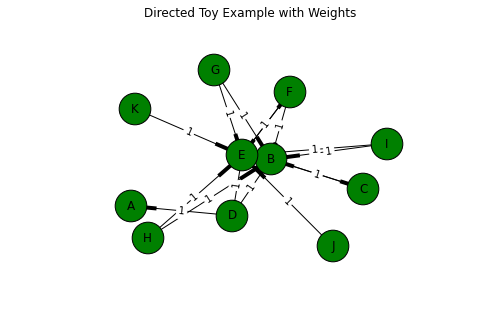

[0] Page Ranks: {'A': 0.09090909090909091, 'C': 0.09090909090909091, 'B': 0.09090909090909091, 'E': 0.09090909090909091, 'D': 0.09090909090909091, 'G': 0.09090909090909091, 'F': 0.09090909090909091, 'I': 0.09090909090909091, 'H': 0.09090909090909091, 'K': 0.09090909090909091, 'J': 0.09090909090909091}


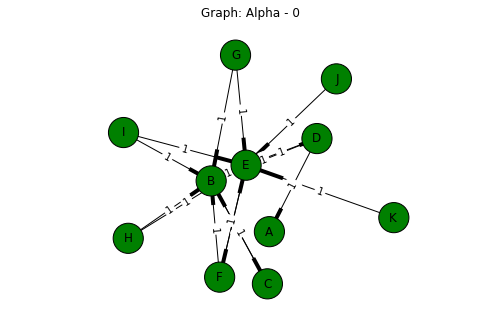

[0.15] Page Ranks: {'A': 0.08478337193849536, 'C': 0.09789412880777816, 'B': 0.12976602705087864, 'E': 0.12595852528732096, 'D': 0.08472680835862145, 'G': 0.07842886603965679, 'F': 0.08472680835862145, 'I': 0.07842886603965679, 'H': 0.07842886603965679, 'K': 0.07842886603965679, 'J': 0.07842886603965679}


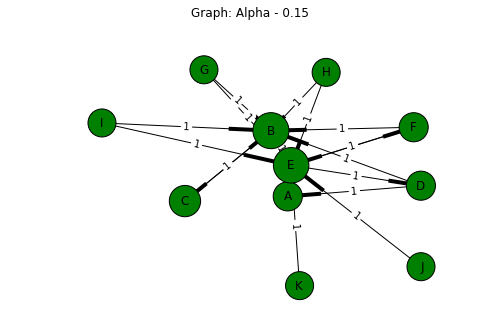

[0.25] Page Ranks: {'A': 0.0802296678675539, 'C': 0.10893861906184224, 'B': 0.15573019947246886, 'E': 0.1414842346470785, 'D': 0.08179558574699461, 'G': 0.07000522149141346, 'F': 0.08179558574699461, 'I': 0.07000522149141346, 'H': 0.07000522149141346, 'K': 0.07000522149141346, 'J': 0.07000522149141346}


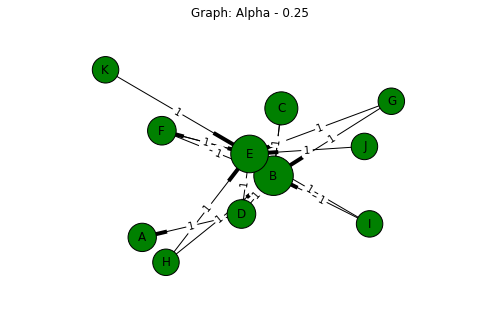

[0.5] Page Ranks: {'A': 0.06694781264624798, 'C': 0.1627142207497308, 'B': 0.22842968831839472, 'E': 0.1518186615813921, 'D': 0.07380073858214373, 'G': 0.048497627907989393, 'F': 0.07380073858214373, 'I': 0.048497627907989393, 'H': 0.048497627907989393, 'K': 0.048497627907989393, 'J': 0.048497627907989393}


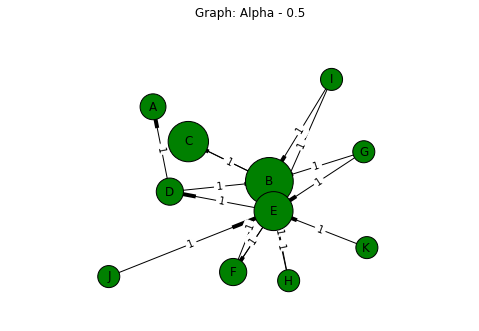

[0.75] Page Ranks: {'A': 0.046301461564296646, 'C': 0.2724191993634685, 'B': 0.32871881246243706, 'E': 0.11424746178750639, 'D': 0.05444605600812519, 'G': 0.025884190561208224, 'F': 0.05444605600812519, 'I': 0.025884190561208224, 'H': 0.025884190561208224, 'K': 0.025884190561208224, 'J': 0.025884190561208224}


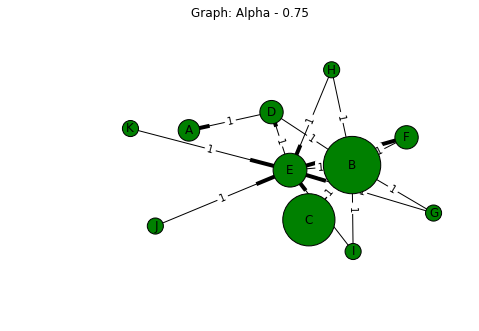

In [154]:
import networkx as nx
import ast
import matplotlib.pyplot as plt
%matplotlib inline

# Flexible Load Data Function
def load_data(filename):
    nodes = set()
    edges = set()
    with open (filename, 'r') as myfile:
        for line in myfile:
            line = line.split('\t')
            node = line[0]
            if node not in nodes:
                nodes.add(node)
            node_neighbors = ast.literal_eval(line[1])
            for k in node_neighbors.keys():
                edges.add((node, k, node_neighbors[k]))
                if k not in nodes:
                    nodes.add(k)
    return nodes, edges

def plot_graph(G, title, node_size=1000):
    # Plot network 
    pos=nx.spring_layout(G, k=0.95)
    nx.draw(G,pos, with_labels = True, node_color='g', node_size=node_size)
    # Specifiy Edge Labels
    edge_labels=dict([((u,v,),d['weight']) for u,v,d in G.edges(data=True)])
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
    plt.title(title)
    plt.show()

nodes, edges = load_data('./PageRank-test.txt')

# Plot Directed Graph
G=nx.DiGraph()

# Load into networkx
for node in nodes:
    G.add_node(node)    
for edge in edges:
    G.add_edge(edge[0], edge[1], weight=edge[2])

plot_graph(G, title="Directed Toy Example with Weights")

NODE_SIZE = 10000
#alpha = [0,0.25,0.5,0.75,1]
alpha = [0,0.15,0.25,0.5,0.75]
for a in alpha:
    pr = nx.pagerank(G, alpha=a)
    print '[{0}] Page Ranks: {1}'.format(a, pr)
    node_size =[NODE_SIZE * v for v in pr.values()]
    #print '[{0}] Node Sizes: {1}\n'.format(a, node_size)
    plot_graph(G, node_size=node_size, title='Graph: Alpha - {0}'.format(a))
        
    

## HW9.3
___

====HW 9.3: Applying PageRank to the Wikipedia hyperlinks network===

Run your PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).

Run your PageRank implementation on the Wikipedia dataset for 50 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). 
Have the top 100 ranked pages changed? Comment on your findings. Plot both 100 curves.

### Pre-Process Wiki Data

***Adds all Dangling Nodes (No Outlinks) as Source***

In [210]:
!python mrjob_preproc_hw91.py all-pages-indexed-out.txt > all-pages-indexed-out.txt.pp

using configs in /Users/ssatpati/.mrjob.conf
creating tmp directory /var/folders/h5/1q71m1c54cn07f16c232pqgm38ynd8/T/mrjob_preproc_hw91.ssatpati.20151102.025510.061810

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to /var/folders/h5/1q71m1c54cn07f16c232pqgm38ynd8/T/mrjob_preproc_hw91.ssatpati.20151102.025510.061810/step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to /var/folders/h5/1q71m1c54cn07f16c232pqgm38ynd8/T/mrjob_preproc_hw91.ssatpati.20151102.025510.061810/step-0-mapper-sorted
> sort /var/folders/h5/1q71m1c54cn07f16c232pqgm38ynd8/T/mrjob_preproc_hw91.ssatpati.20151102.025510.061810/step-0-mapper_part-00000
writing to /var/folders/h5/1q71m1c54cn07f16c232pqgm38ynd8/T/mrjob_preproc_hw91.ssatpati.20151102.025510.061810/step-0-reducer_part-00000
Count

### Making Minor Changes to the MRJOB Page Rank from 9.1 to make it AWS Compatible

In [211]:
%%writefile mrjob_hw93.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol
from mrjob.compat import get_jobconf_value
import sys
import ast
from numpy import log1p, exp, log
from boto.s3.connection import S3Connection
from boto.s3.key import Key
import boto

class PageRank_AWS(MRJob):
    
    INPUT_PROTOCOL = RawProtocol
    
    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                  reducer=self.reducer),
            MRStep(mapper_init=self.mapper_dangling_init,
                mapper=self.mapper_dangling)
        ]
    

    def mapper(self, key, value):
        nodes = int(get_jobconf_value('nodes'))
        i = int(get_jobconf_value('iteration'))
        #sys.stderr.write('[M] {0}, {1} \n'.format(key, value))
        key = key.replace("\"","")
        key = key.replace("\\","")
        adj_list = ast.literal_eval(value)
      
        score = 0
        l = 0
        
        if 'score' in adj_list.keys():
            # Previous Mass/Page Rank
            score = adj_list['score']
            l = len(adj_list) - 1
        else: # First iteration ('score' not yet part of the adjacency list!)
            # Start with uniform probability distribution
            score = 1.0 / nodes
            l = len(adj_list)
            adj_list['score'] = score
            
        if l == 0: # Only 'score' & no out links [Dangling!]
            sys.stderr.write('[{0}][M] "DANGLING MASS" | {1} | {2}\n'.format(i, key, score))
            # Emit using a special key; Accumlate in Reducer;Distribute in the next MRJob
            yield 'DANGLING', ('SCORE', score)
       
        # Emit the Graph Structure
        yield key, ('GRAPH', adj_list)
                    
        # Emit the new Mass/Page Rank
        for n in adj_list:
            if n != 'score':
                yield n, ('SCORE', score/l)
                               
    def combiner(self, key, values):
        pass

        
    def reducer(self, key, values):     
        i = int(get_jobconf_value('iteration'))
        teleportation = float(get_jobconf_value('teleportation'))
        nodes = int(get_jobconf_value('nodes'))
        aws_access_key_id = get_jobconf_value('aws_access_key_id')
        aws_secret_access_key = get_jobconf_value('aws_secret_access_key')
        
        adj_list = None
        total_score = 0

        for value_type, value in values:
            if value_type == 'GRAPH':
                adj_list = value
            else:
                assert value_type == 'SCORE'
                total_score += value
                #total_score = sum_log(total_score, value)
                
        # Write Special Key to S3
        if key == 'DANGLING':
            # Write accumulated Dangling Score in a S3 Key
            try:
                conn = S3Connection(aws_access_key_id,aws_secret_access_key)
                bucket = conn.get_bucket('w261')
                k = Key(bucket)
                k.key = 'hw93/dangling_mass/{0}'.format(i) # Same as iteration
                k.set_contents_from_string(str(total_score))
            except boto.exception.S3ResponseError as err:
                sys.stderr.write(err)
                sys.exit(1)
        else:
            #total_score = (teleportation / nodes) + ((1 - teleportation) * total_score)
            #total_score = sum_log((teleportation / nodes), ((1 - teleportation) * total_score))
            if adj_list:
                adj_list['score'] = total_score
            else:
                adj_list = {'score': total_score}
    
            #sys.stderr.write('[R2] {0} | {1} | {2}\n\n'.format(key, total_score, adj_list))
            yield key, adj_list
       

    def mapper_dangling_init(self):
        i = int(get_jobconf_value('iteration'))
        aws_access_key_id = get_jobconf_value('aws_access_key_id')
        aws_secret_access_key = get_jobconf_value('aws_secret_access_key')
        
        self.dangling_mass = 0
        
        # Read Dangling Mass from S3 Bucket
        try:
            conn = S3Connection(aws_access_key_id,aws_secret_access_key)
            bucket = conn.get_bucket('w261')
            k = Key(bucket)
            k.key = 'hw93/dangling_mass/{0}'.format(i) # Same as iteration
            self.dangling_mass = float(k.get_contents_as_string())
        except boto.exception.S3ResponseError as err:
            sys.stderr.write(err)
            sys.exit(1)
        
        sys.stderr.write('[{0}][M_D] DANGLING MASS: {1}\n'.format(i, self.dangling_mass))
        
    def mapper_dangling(self, key, value):
        #sys.stderr.write('[M_D] {0}, {1} \n'.format(key, value))
        i = int(get_jobconf_value('iteration'))
        key = key.replace("\"","")
        key = key.replace("\\","")
        adj_list = ast.literal_eval(str(value))
        
        if self.dangling_mass > 0:
            nodes = int(get_jobconf_value('nodes'))
            teleportation = float(get_jobconf_value('teleportation'))
            score = adj_list['score']
            modified_score = (teleportation / nodes) + (1 - teleportation) * ((self.dangling_mass / nodes) + score)
            #modified_score = sum_log((teleportation / nodes), (1 - teleportation)*(self.dangling_mass / nodes))
            #modified_score = sum_log(modified_score, (1 - teleportation)*score)
            adj_list['score'] = modified_score
            
        yield key, adj_list
        

   
if __name__ == '__main__':
    PageRank_AWS.run()

Writing mrjob_hw93.py


In [212]:
!chmod a+x mrjob_hw93.py

### === Wikipedia Dataset: 10 Iterations ===

In [226]:
%reload_ext autoreload
%autoreload 2
from mrjob_hw93 import PageRank_AWS
import ast
import sys
import pprint


cnt = 0
MAX_ITERATIONS = 10
NODES = 15192277
TELEPORTATION = 0.15

# Delete Existing Output
!aws s3 rm --recursive s3://w261/hw93/output/

aws_creds = {}
with open("/Users/ssatpati/.aws/credentials", "r") as f:
    for l in f:
        if l.startswith('aws'):
            t = l.split('=')
            aws_creds[t[0].strip()] = t[1].strip()

# After so many iterations (TBD: Convergence Criteria)
while cnt < MAX_ITERATIONS:
    print "\n\n Start Iteration: " + str(cnt+1) + ":"
    
    out_dir = 's3://w261/hw93/output/{0}'.format(cnt)
    print 'Output Dir: {0}'.format(out_dir)
    
    if cnt == 0:
        mr_job = PageRank_AWS(args=['-r', 'emr', 's3://w261/all-pages-indexed-out.txt.pp',
                                '--output-dir', out_dir,
                                '--jobconf', 'teleportation={0}'.format(TELEPORTATION),
                                '--jobconf', 'nodes={0}'.format(NODES),
                                '--jobconf', 'iteration={0}'.format(cnt+1),
                                '--jobconf', 'aws_access_key_id={0}'.format(aws_creds['aws_access_key_id']),
                                '--jobconf', 'aws_secret_access_key={0}'.format(aws_creds['aws_secret_access_key']),
                                '--no-strict-protocol',
                                '--pool-emr-job-flows', 
                                '--max-hours-idle', '1',
                                '--no-strict-protocol'])
    else:
        mr_job = PageRank_AWS(args=['-r', 'emr', 's3://w261/hw93/output/{0}/'.format(cnt-1),
                                '--output-dir', out_dir,
                                '--jobconf', 'teleportation={0}'.format(TELEPORTATION),
                                '--jobconf', 'nodes={0}'.format(NODES),
                                '--jobconf', 'iteration={0}'.format(cnt+1),
                                '--jobconf', 'aws_access_key_id={0}'.format(aws_creds['aws_access_key_id']),
                                '--jobconf', 'aws_secret_access_key={0}'.format(aws_creds['aws_secret_access_key']),
                                '--no-strict-protocol',
                                '--pool-emr-job-flows', 
                                '--max-hours-idle', '1',
                                '--no-strict-protocol'])

    with mr_job.make_runner() as runner: 
        runner.run()
                                
    cnt += 1
    



 Start Iteration: 1:
Output Dir: s3://w261/hw93/output/0


 Start Iteration: 2:


Output Dir: s3://w261/hw93/output/1


 Start Iteration: 3:


Output Dir: s3://w261/hw93/output/2


 Start Iteration: 4:


Output Dir: s3://w261/hw93/output/3


 Start Iteration: 5:


Output Dir: s3://w261/hw93/output/4


 Start Iteration: 6:


Output Dir: s3://w261/hw93/output/5


 Start Iteration: 7:


Output Dir: s3://w261/hw93/output/6


 Start Iteration: 8:


Output Dir: s3://w261/hw93/output/7


 Start Iteration: 9:


Output Dir: s3://w261/hw93/output/8


 Start Iteration: 10:


Output Dir: s3://w261/hw93/output/9


### === Wikipedia Dataset: 50 Iterations ===

In [225]:
%reload_ext autoreload
%autoreload 2
from mrjob_hw93 import PageRank_AWS
import ast
import sys
import pprint


cnt = 0
MAX_ITERATIONS = 50
NODES = 15192277
TELEPORTATION = 0.15

# Delete Existing Output
!aws s3 rm --recursive s3://w261/hw93/output1/

aws_creds = {}
with open("/Users/ssatpati/.aws/credentials", "r") as f:
    for l in f:
        if l.startswith('aws'):
            t = l.split('=')
            aws_creds[t[0].strip()] = t[1].strip()

# After so many iterations (TBD: Convergence Criteria)
while cnt < MAX_ITERATIONS:
    print "\n\n Start Iteration: " + str(cnt+1) + ":"
    
    out_dir = 's3://w261/hw93/output1/{0}'.format(cnt)
    print 'Output Dir: {0}'.format(out_dir)
    
    if cnt == 0:
        mr_job = PageRank_AWS(args=['-r', 'emr', 's3://w261/all-pages-indexed-out.txt.pp',
                                '--output-dir', out_dir,
                                '--jobconf', 'teleportation={0}'.format(TELEPORTATION),
                                '--jobconf', 'nodes={0}'.format(NODES),
                                '--jobconf', 'iteration={0}'.format(cnt+1),
                                '--jobconf', 'aws_access_key_id={0}'.format(aws_creds['aws_access_key_id']),
                                '--jobconf', 'aws_secret_access_key={0}'.format(aws_creds['aws_secret_access_key']),
                                '--no-strict-protocol',
                                '--pool-emr-job-flows', 
                                '--max-hours-idle', '1',
                                '--no-strict-protocol'])
    else:
        mr_job = PageRank_AWS(args=['-r', 'emr', 's3://w261/hw93/output1/{0}/'.format(cnt-1),
                                '--output-dir', out_dir,
                                '--jobconf', 'teleportation={0}'.format(TELEPORTATION),
                                '--jobconf', 'nodes={0}'.format(NODES),
                                '--jobconf', 'iteration={0}'.format(cnt+1),
                                '--jobconf', 'aws_access_key_id={0}'.format(aws_creds['aws_access_key_id']),
                                '--jobconf', 'aws_secret_access_key={0}'.format(aws_creds['aws_secret_access_key']),
                                '--no-strict-protocol',
                                '--pool-emr-job-flows', 
                                '--max-hours-idle', '1',
                                '--no-strict-protocol'])

    with mr_job.make_runner() as runner: 
        runner.run()
                                
    cnt += 1
    



 Start Iteration: 1:
Output Dir: s3://w261/hw93/output1/0


 Start Iteration: 2:


Output Dir: s3://w261/hw93/output1/1


 Start Iteration: 3:


Output Dir: s3://w261/hw93/output1/2


 Start Iteration: 4:


Output Dir: s3://w261/hw93/output1/3


 Start Iteration: 5:


Output Dir: s3://w261/hw93/output1/4


 Start Iteration: 6:


Output Dir: s3://w261/hw93/output1/5


 Start Iteration: 7:


Output Dir: s3://w261/hw93/output1/6


 Start Iteration: 8:


Output Dir: s3://w261/hw93/output1/7


 Start Iteration: 9:


Output Dir: s3://w261/hw93/output1/8


 Start Iteration: 10:


Output Dir: s3://w261/hw93/output1/9


 Start Iteration: 11:


Output Dir: s3://w261/hw93/output1/10


 Start Iteration: 12:


Output Dir: s3://w261/hw93/output1/11


 Start Iteration: 13:


Output Dir: s3://w261/hw93/output1/12


 Start Iteration: 14:


Output Dir: s3://w261/hw93/output1/13


 Start Iteration: 15:


Output Dir: s3://w261/hw93/output1/14


 Start Iteration: 16:


Output Dir: s3://w261/hw93/output1/15


 Start Iteration: 17:


Output Dir: s3://w261/hw93/output1/16


 Start Iteration: 18:


Output Dir: s3://w261/hw93/output1/17


 Start Iteration: 19:


Output Dir: s3://w261/hw93/output1/18


 Start Iteration: 20:


Output Dir: s3://w261/hw93/output1/19


 Start Iteration: 21:


Output Dir: s3://w261/hw93/output1/20


 Start Iteration: 22:


Output Dir: s3://w261/hw93/output1/21


 Start Iteration: 23:


Output Dir: s3://w261/hw93/output1/22


 Start Iteration: 24:


Output Dir: s3://w261/hw93/output1/23


 Start Iteration: 25:


Output Dir: s3://w261/hw93/output1/24


 Start Iteration: 26:


Output Dir: s3://w261/hw93/output1/25


 Start Iteration: 27:


Output Dir: s3://w261/hw93/output1/26


 Start Iteration: 28:


Output Dir: s3://w261/hw93/output1/27


 Start Iteration: 29:


Output Dir: s3://w261/hw93/output1/28


 Start Iteration: 30:


Output Dir: s3://w261/hw93/output1/29


 Start Iteration: 31:


Output Dir: s3://w261/hw93/output1/30


 Start Iteration: 32:


Output Dir: s3://w261/hw93/output1/31


 Start Iteration: 33:


Output Dir: s3://w261/hw93/output1/32


 Start Iteration: 34:


Output Dir: s3://w261/hw93/output1/33


 Start Iteration: 35:


Output Dir: s3://w261/hw93/output1/34


 Start Iteration: 36:


Output Dir: s3://w261/hw93/output1/35


 Start Iteration: 37:


Output Dir: s3://w261/hw93/output1/36


 Start Iteration: 38:


Output Dir: s3://w261/hw93/output1/37


 Start Iteration: 39:


Output Dir: s3://w261/hw93/output1/38


 Start Iteration: 40:


Output Dir: s3://w261/hw93/output1/39


 Start Iteration: 41:


Output Dir: s3://w261/hw93/output1/40


 Start Iteration: 42:


Output Dir: s3://w261/hw93/output1/41


 Start Iteration: 43:


Output Dir: s3://w261/hw93/output1/42


 Start Iteration: 44:


Output Dir: s3://w261/hw93/output1/43


 Start Iteration: 45:


Output Dir: s3://w261/hw93/output1/44


 Start Iteration: 46:


Output Dir: s3://w261/hw93/output1/45


 Start Iteration: 47:


Output Dir: s3://w261/hw93/output1/46


 Start Iteration: 48:


Output Dir: s3://w261/hw93/output1/47


 Start Iteration: 49:


Output Dir: s3://w261/hw93/output1/48


 Start Iteration: 50:


Output Dir: s3://w261/hw93/output1/49


### Generic MRJob to find the top_N Values

In [227]:
%%writefile mrjob_hw93_top100.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol
from mrjob.compat import get_jobconf_value
import ast,sys


class TopNPageRanks(MRJob):
    
    INPUT_PROTOCOL = RawProtocol
    
    def steps(self):
        return [
            MRStep(mapper_init=self.mapper_topN_init,
                   mapper=self.mapper_topN,
                   mapper_final=self.mapper_topN_final,
                   reducer_init=self.reducer_topN_init,
                   reducer=self.reducer_topN,
                   reducer_final=self.reducer_topN_final,
                   jobconf={
                            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                            'mapred.text.key.comparator.options': '-k1,1rn',
                            'mapred.reduce.tasks': 1
                            }
                  )
        ]
    
    def mapper_topN_init(self):
        self.TOP_N = 100
        self.top_N_pairs = []
    
    def mapper_topN(self, key, value):
        key = key.replace("\"","")
        key = key.replace("\\","")
        adj_list = ast.literal_eval(value)
        
        self.top_N_pairs.append((adj_list['score'], key))
        if len(self.top_N_pairs) > self.TOP_N:
            self.top_N_pairs.sort(key=lambda x: -x[0])
            self.top_N_pairs = self.top_N_pairs[:self.TOP_N]
            
    def mapper_topN_final(self):
        sys.stderr.write('##### [Mapper_Final]: {0}\n'.format(len(self.top_N_pairs)))
        for e in self.top_N_pairs:
            yield e[0], e[1]
        
    def reducer_topN_init(self):
        self.TOP_N = 100
        self.top_N_pairs = []
            
    def reducer_topN(self, key, values):
        for value in values:
            self.top_N_pairs.append((key, value))
        if len(self.top_N_pairs) > self.TOP_N:
            self.top_N_pairs.sort(key=lambda x: -x[0])
            self.top_N_pairs = self.top_N_pairs[:self.TOP_N]
        
    def reducer_topN_final(self):
        sys.stderr.write('##### [Reducer_Final]: {0}\n'.format(len(self.top_N_pairs)))
        for e in self.top_N_pairs:
            yield e[0], e[1]
    
if __name__ == '__main__':
    TopNPageRanks.run()

Overwriting mrjob_hw93_top100.py


In [228]:
!chmod a+x mrjob_hw93_top100.py

### Find Top 100 Page Ranks - Page Rank run with 10 iterations

In [229]:
!aws s3 rm --recursive s3://w261/hw93/output_top100/
!python mrjob_hw93_top100.py -q -r emr \
 s3://w261/hw93/output/9/ \
 --output-dir=s3://w261/hw93/output_top100/ \
 --no-strict-protocol

0.0014614491944077389	"13455888"
0.00066633173766243422	"1184351"
0.00063980518762376919	"4695850"
0.00057485388269411393	"5051368"
0.00045030471433506045	"1384888"
0.00044660099103889728	"2437837"
0.00044481824807235642	"6113490"
0.00044420373464869881	"7902219"
0.00043299524497309111	"13425865"
0.00042788533618055163	"6076759"
0.00042327595495435119	"4196067"
0.00039817029591602925	"6172466"
0.00038543367085079497	"14112583"
0.00036316706608724214	"10390714"
0.00034383110767296387	"15164193"
0.00033834786525998662	"3191491"
0.00032935246269550836	"6416278"
0.00032896996560107043	"6237129"
0.00032632071990416434	"7835160"
0.00032507588819237655	"1516699"
0.00031314344183987756	"13725487"
0.00030959412428348937	"9276255"
0.00030809546901865501	"7576704"
0.00030354256664463141	"10469541"
0.00029795335224561066	"5154210"
0.00028579029429588303	"12836211"
0.00028347554325984384	"7990491"
0.00026906211185536929	"4198751"
0.00026401327507796166	"2797855"
0.0002610656557758054	"11253108"
0.0

In [231]:
!aws s3 cp s3://w261/hw93/output_top100/part-00000 .
!mv part-00000 wiki_pagerank_10_iter.txt
!ls -l wiki_pagerank_10_iter.txt

download: s3://w261/hw93/output_top100/part-00000 to ./part-00000
-rw-r--r--  1 ssatpati  110056872  3325 Nov  2 09:44 wiki_pagerank_10_iter.txt


### Find Top 100 Page Ranks - Page Rank run with 50 iterations

In [230]:
!aws s3 rm --recursive s3://w261/hw93/output1_top100/
!python mrjob_hw93_top100.py -q -r emr \
 s3://w261/hw93/output1/49/ \
 --output-dir=s3://w261/hw93/output1_top100/ \
 --no-strict-protocol

0.0014615599818950051	"13455888"
0.00066601779372097683	"1184351"
0.00063967737583050523	"4695850"
0.00057476719839043657	"5051368"
0.00045012322227649135	"1384888"
0.00044667005175968869	"2437837"
0.00044463224410275795	"6113490"
0.0004438786997350172	"7902219"
0.00043314218180878674	"13425865"
0.00042770776778149028	"6076759"
0.0004234167960369039	"4196067"
0.0003978260420823735	"6172466"
0.00038548623802966812	"14112583"
0.00036266653374319579	"10390714"
0.00034358745306681032	"15164193"
0.00033804961292161411	"3191491"
0.00032922032693070687	"6416278"
0.00032899474585342399	"6237129"
0.00032620175387261427	"7835160"
0.00032511085577420685	"1516699"
0.00031268227727687247	"13725487"
0.00030956927415565032	"9276255"
0.00030798064684121803	"7576704"
0.00030312038150828464	"10469541"
0.00029754778736255287	"5154210"
0.00028603760472187013	"12836211"
0.00028362017803191739	"7990491"
0.0002690535556513846	"4198751"
0.00026401414748113274	"2797855"
0.00026098474385061974	"11253108"
0.0002

In [232]:
!aws s3 cp s3://w261/hw93/output1_top100/part-00000 .
!mv part-00000 wiki_pagerank_50_iter.txt
!ls -l wiki_pagerank_50_iter.txt

download: s3://w261/hw93/output1_top100/part-00000 to ./part-00000
-rw-r--r--  1 ssatpati  110056872  3323 Nov  2 09:53 wiki_pagerank_50_iter.txt


### Analyzing the Ranks from 2 Runs

In [233]:
# Load Indices
index = {}
with open('indices.txt') as f:
    for l in f:
        t  = l.strip().split('\t')
        index[t[1].strip()] = t[0].strip()

In [234]:
#Load Page Ranks
pr1 = []
pr2 = []
with open('wiki_pagerank_10_iter.txt') as f:
    for l in f:
        t  = l.strip().split('\t')
        pr1.append((t[0], t[1]))
        
with open('wiki_pagerank_50_iter.txt') as f:
    for l in f:
        t  = l.strip().split('\t')
        pr2.append((t[0], t[1]))

In [245]:
print "### Format: <Rank_Iter_10> <PageIter_10> <Rank_Iter_50> <PageIter_50>\n\n"
for i in xrange(50):
    print '{0}\t{1}, {2}\t{3}'.format(pr1[i][0], 
                                      index.get(pr1[i][1].replace("\"",""), 'NA'),
                                      pr2[i][0], 
                                      index.get(pr2[i][1].replace("\"",""), 'NA'))

### Format: <Rank_Iter_10> <PageIter_10> <Rank_Iter_50> <PageIter_50>


0.0014614491944077389	United States, 0.0014615599818950051	United States
0.00066633173766243422	Animal, 0.00066601779372097683	Animal
0.00063980518762376919	France, 0.00063967737583050523	France
0.00057485388269411393	Germany, 0.00057476719839043657	Germany
0.00045030471433506045	Arthropod, 0.00045012322227649135	Arthropod
0.00044660099103889728	Canada, 0.00044667005175968869	Canada
0.00044481824807235642	Insect, 0.00044463224410275795	Insect
0.00044420373464869881	List of sovereign states, 0.0004438786997350172	List of sovereign states
0.00043299524497309111	United Kingdom, 0.00043314218180878674	United Kingdom
0.00042788533618055163	India, 0.00042770776778149028	India
0.00042327595495435119	England, 0.0004234167960369039	England
0.00039817029591602925	Iran, 0.0003978260420823735	Iran
0.00038543367085079497	World War II, 0.00038548623802966812	World War II
0.00036316706608724214	Poland, 0.00036266653374319579	Pola

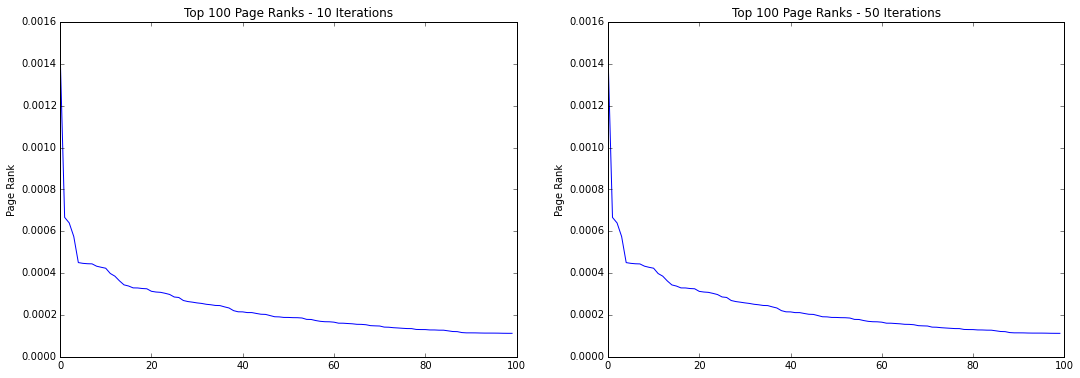

In [252]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(18,6))
plt.subplot(121)
plt.title("Top 100 Page Ranks - 10 Iterations")
plt.ylabel('Page Rank')
plt.plot([pr[0] for pr in pr1])

plt.subplot(122)
plt.title("Top 100 Page Ranks - 50 Iterations")
plt.ylabel('Page Rank')
plt.plot([pr[0] for pr in pr2])

## HW94
___


===HW 9.4: Topic-specific PageRank implementation using MRJob===

Modify your PageRank implementation to produce a topic specific PageRank implementation,
as described in:

http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf

Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.
This caveat lies in footnote 3 on page 3:

	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.

and must be adhered to for convergence to be guaranteed.

Run topic specific PageRank on the following randomly generated network of 100 nodes:

s3://ucb-mids-mls-networks/randNet.txt

which are organized into ten topics, as described in the file:

s3://ucb-mids-mls-networks/randNet_topics.txt

Since there are 10 topics, your result should be 11 PageRank vectors
(one for the vanilla PageRank implementation in 9.1, and one for each topic
with the topic specific implementation). Print out the top ten ranking nodes 
and their topics for each of the 11 versions, and comment on your result. 
Assume a teleportation factor of 0.15 in all your analyses.

In [49]:
%%writefile mrjob_hw94.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol
from mrjob.compat import get_jobconf_value
import sys
import ast
from numpy import log1p, exp, log

class TopicPageRank(MRJob):
    
    INPUT_PROTOCOL = RawProtocol
    
    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                  reducer=self.reducer),
            MRStep(mapper_init=self.mapper_dangling_init,
                mapper=self.mapper_dangling)
        ]
    

    def mapper(self, key, value):
        nodes = int(get_jobconf_value('nodes'))
        i = int(get_jobconf_value('iteration'))
        #sys.stderr.write('[M] {0}, {1} \n'.format(key, value))
        key = key.replace("\"","")
        key = key.replace("\\","")
        adj_list = ast.literal_eval(value)
      
        score = 0
        l = 0
        
        if 'score' in adj_list.keys():
            # Previous Mass/Page Rank
            score = adj_list['score']
            l = len(adj_list) - 1
        else: # First iteration ('score' not yet part of the adjacency list!)
            # Start with uniform probability distribution
            score = 1.0 / nodes
            l = len(adj_list)
            adj_list['score'] = score
            
        if l == 0: # Only 'score' & no out links [Dangling!]
            sys.stderr.write('[{0}][M] "DANGLING MASS" | {1} | {2}\n'.format(i, key, score))
            # Emit using a special key; Accumlate in Reducer;Distribute in the next MRJob
            yield 'DANGLING', ('SCORE', score)
       
        # Emit the Graph Structure
        yield key, ('GRAPH', adj_list)
                    
        # Emit the new Mass/Page Rank
        for n in adj_list:
            if n != 'score':
                yield n, ('SCORE', score/l)
                               
    def combiner(self, key, values):
        pass

        
    def reducer(self, key, values):     
        i = int(get_jobconf_value('iteration'))
        teleportation = float(get_jobconf_value('teleportation'))
        nodes = int(get_jobconf_value('nodes'))
        
        adj_list = None
        total_score = 0

        for value_type, value in values:
            if value_type == 'GRAPH':
                adj_list = value
            else:
                assert value_type == 'SCORE'
                total_score += value
                #total_score = sum_log(total_score, value)
                
        # Special Key
        if key == 'DANGLING':
            # Write accumulated Dangling Score in a file
            with open('/Users/ssatpati/0-DATASCIENCE/DEV/github/ml/w261/wk9/dangling.txt', 'w') as f:
                f.write('DANGLING\t{0}\n'.format(total_score))
        else:
            #total_score = (teleportation / nodes) + ((1 - teleportation) * total_score)
            #total_score = sum_log((teleportation / nodes), ((1 - teleportation) * total_score))
            if adj_list:
                adj_list['score'] = total_score
            else:
                adj_list = {'score': total_score}
    
            #sys.stderr.write('[R2] {0} | {1} | {2}\n\n'.format(key, total_score, adj_list))
            yield key, adj_list
       

    def mapper_dangling_init(self):
        i = int(get_jobconf_value('iteration'))
        
        # Page/Topic Mapping & Topic Counts for each Topic.
        self.topics = {}
        self.topicCounts = {}
        with open('randNet_topics.txt') as f:
            for l in f:
                t = l.split('\t')
                self.topics[t[0].strip()] = t[1].strip()
                
        for k,v in self.topics.iteritems():
            self.topicCounts[v] = self.topicCounts.get(v, 0) + 1
        
        self.dangling_mass = 0
        f_dangling = '/Users/ssatpati/0-DATASCIENCE/DEV/github/ml/w261/wk9/dangling.txt'
        try:
            with open(f_dangling, 'r') as f:
                l = f.readlines()
                if l:
                    self.dangling_mass = float(l[0].split('\t')[1])
            open(f_dangling, 'w').close()
        except Exception as e:
            pass
        #sys.stderr.write('[{0}][M_D] DANGLING MASS: {1}\n'.format(i, self.dangling_mass))
        
    def mapper_dangling(self, key, value):
        # Topic of Current Node
        topic = get_jobconf_value('topic')
        # Number of Nodes in same Topic as current Node
        n_nodes_topic = self.topicCounts.get(topic, 0)
        
        #sys.stderr.write('[M_D] {0}, {1}, {2} \n'.format(key, topic, n_nodes_topic)) 
        
        i = int(get_jobconf_value('iteration'))
        key = key.replace("\"","")
        key = key.replace("\\","")
        adj_list = ast.literal_eval(str(value))
        
        nodes = int(get_jobconf_value('nodes'))
        teleportation = float(get_jobconf_value('teleportation'))
        topic_bias = float(get_jobconf_value('topic_bias'))
        
        score = adj_list['score']
        
        '''
            Adjust for Topic Bias
            Random Surfer selects Nodes in same Topic as current node using a Topic Bias (> 0.5: Topic Sensitive)
        '''
        if topic != '0':
            random_topic_jump = teleportation * ((topic_bias/n_nodes_topic) + ((1 - topic_bias)/ (nodes - n_nodes_topic)))
            modified_score = random_topic_jump + (1 - teleportation) * ((self.dangling_mass / nodes) + score)
        else:
            modified_score = (teleportation / nodes) + (1 - teleportation) * ((self.dangling_mass / nodes) + score)
        
        #modified_score = (teleportation / nodes) + (1 - teleportation) * ((self.dangling_mass / nodes) + score)
        #modified_score = sum_log((teleportation / nodes), (1 - teleportation)*(self.dangling_mass / nodes))
        #modified_score = sum_log(modified_score, (1 - teleportation)*score)
        adj_list['score'] = modified_score
            
        yield key, adj_list
        

   
if __name__ == '__main__':
    TopicPageRank.run()

Overwriting mrjob_hw94.py


In [50]:
!chmod a+x mrjob_hw94.py

In [52]:
%reload_ext autoreload
%autoreload 2
from mrjob_hw94 import TopicPageRank
import ast
import sys
import pprint

input_file = 'randNet.txt'
input_file_iter = input_file + '1'

cnt = 0
MAX_ITERATIONS = 100
NODES = 100
TELEPORTATION = 0.15
TOPIC_BIAS = 0.99

topics = [i for i in xrange(10+1)]
tpr = {}

print 'TOPICS: {0}'.format(topics)

for topic in topics:
    
    prev_ranks = []
    curr_ranks = []
    sum_partial_diff_PR = float('inf')

    # After so many iterations (TBD: Convergence Criteria)
    while sum_partial_diff_PR > .0005:
        print '### Iteration: {0}, Topic {1}:'.format(cnt+1, topic)
        if cnt == 0:
            mr_job = TopicPageRank(args=[input_file,
                                    '--file', 'randNet_topics.txt',
                                    '--jobconf', 'teleportation={0}'.format(TELEPORTATION),
                                    '--jobconf', 'topic_bias={0}'.format(TOPIC_BIAS),
                                    '--jobconf', 'topic={0}'.format(topic),
                                    '--jobconf', 'nodes={0}'.format(NODES),
                                    '--jobconf', 'iteration={0}'.format(cnt+1),
                                    '--no-strict-protocol'])
        else:
            mr_job = TopicPageRank(args=[input_file_iter,
                                    '--file', 'randNet_topics.txt',
                                    '--jobconf', 'teleportation={0}'.format(TELEPORTATION),
                                    '--jobconf', 'topic_bias={0}'.format(TOPIC_BIAS),
                                    '--jobconf', 'topic={0}'.format(topic),
                                    '--jobconf', 'nodes={0}'.format(NODES),
                                    '--jobconf', 'iteration={0}'.format(cnt+1),
                                    '--no-strict-protocol'])

        with mr_job.make_runner() as runner: 
            runner.run()

            if cnt == 0:
                prev_ranks = [(i+1, 0) for i in xrange(NODES)]
            else:
                prev_ranks = curr_ranks[:]
                del curr_ranks[:]

            total_page_rank = 0
            ranks = []
            with open(input_file_iter, 'w') as f:
                for line in runner.stream_output():
                    parsed_line = mr_job.parse_output_line(line)

                    #print parsed_line
                    neigbors = ast.literal_eval(str(parsed_line[1]))
                    total_page_rank += float(neigbors['score'])

                    curr_ranks.append((parsed_line[0], round(neigbors['score'], 3)))

                    f.write(line)

            sum_partial_diff_PR = sum([abs(x[1]-y[1]) for x,y in zip(curr_ranks, prev_ranks)])

            print "#Iteration: {0}, Page Rank (Sum): {1}".format(cnt + 1, total_page_rank)
            print "#Iteration: {0}, Difference in Ranks: {1}".format(cnt + 1, sum_partial_diff_PR)
            #print 'Prev Page Ranks: ', prev_ranks
            #print 'Curr Page Ranks: ', curr_ranks

        cnt += 1
    
    tpr[topic] = sorted(curr_ranks, key=lambda x: -x[1])[:10]
    print '\n### Final Page Rank, Topic {0}: \n{1}\n\n'.format(topic, sorted(curr_ranks, key=lambda x: -x[1])[:10])
    
print '\n### PAGE RANK SUMMARY ###\n'    
for k,v in tpr.iteritems():
    print '\n# Topic: {0}\n'.format(k)
    print v
    

TOPICS: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
### Iteration: 1, Topic 0:
#Iteration: 1, Page Rank (Sum): 1.0
#Iteration: 1, Difference in Ranks: 1.002
### Iteration: 2, Topic 0:
#Iteration: 2, Page Rank (Sum): 1.0
#Iteration: 2, Difference in Ranks: 0.048
### Iteration: 3, Topic 0:
#Iteration: 3, Page Rank (Sum): 1.0
#Iteration: 3, Difference in Ranks: 0.016
### Iteration: 4, Topic 0:
#Iteration: 4, Page Rank (Sum): 1.0
#Iteration: 4, Difference in Ranks: 0.004
### Iteration: 5, Topic 0:
#Iteration: 5, Page Rank (Sum): 1.0
#Iteration: 5, Difference in Ranks: 0.001
### Iteration: 6, Topic 0:
#Iteration: 6, Page Rank (Sum): 1.0
#Iteration: 6, Difference in Ranks: 0.001
### Iteration: 7, Topic 0:
#Iteration: 7, Page Rank (Sum): 1.0
#Iteration: 7, Difference in Ranks: 0.0

### Final Page Rank, Topic 0: 
[('15', 0.016), ('63', 0.016), ('74', 0.016), ('100', 0.015), ('58', 0.015), ('85', 0.015), ('9', 0.015), ('52', 0.014), ('61', 0.014), ('71', 0.014)]


### Iteration: 8, Topic 1:
#Iteration: 

### ============= PAGE RANK SUMMARY ============= ###

```
# Topic: 0 (No Topic or BASE CASE)

[('15', 0.016), ('63', 0.016), ('74', 0.016), ('100', 0.015), ('58', 0.015), ('85', 0.015), ('9', 0.015), ('52', 0.014), ('61', 0.014), ('71', 0.014)]

# Topic: 1

[('15', 0.024), ('100', 0.023), ('63', 0.023), ('74', 0.023), ('52', 0.022), ('58', 0.022), ('61', 0.022), ('71', 0.022), ('85', 0.022), ('9', 0.022)]

# Topic: 2

[('15', 0.044), ('100', 0.043), ('63', 0.043), ('74', 0.043), ('85', 0.042), ('9', 0.042), ('58', 0.041), ('61', 0.041), ('71', 0.041), ('52', 0.04)]

# Topic: 3

[('15', 0.065), ('63', 0.065), ('100', 0.064), ('74', 0.062), ('9', 0.062), ('85', 0.061), ('58', 0.06), ('61', 0.059), ('71', 0.059), ('52', 0.057)]

# Topic: 4

[('15', 0.077), ('63', 0.076), ('100', 0.074), ('74', 0.074), ('9', 0.073), ('85', 0.071), ('58', 0.07), ('61', 0.069), ('71', 0.069), ('52', 0.068)]

# Topic: 5

[('15', 0.089), ('63', 0.088), ('74', 0.087), ('100', 0.086), ('85', 0.084), ('9', 0.084), ('58', 0.082), ('61', 0.08), ('71', 0.08), ('52', 0.079)]

# Topic: 6

[('15', 0.111), ('63', 0.109), ('74', 0.108), ('100', 0.107), ('85', 0.104), ('9', 0.104), ('58', 0.102), ('61', 0.1), ('71', 0.1), ('52', 0.099)]

# Topic: 7

[('15', 0.125), ('63', 0.122), ('74', 0.121), ('100', 0.12), ('9', 0.117), ('85', 0.116), ('58', 0.113), ('61', 0.111), ('71', 0.111), ('52', 0.108)]

# Topic: 8

[('15', 0.132), ('63', 0.129), ('74', 0.129), ('100', 0.125), ('85', 0.123), ('9', 0.123), ('58', 0.12), ('71', 0.118), ('52', 0.117), ('61', 0.117)]

# Topic: 9

[('15', 0.144), ('74', 0.141), ('63', 0.14), ('100', 0.137), ('85', 0.134), ('9', 0.134), ('58', 0.132), ('71', 0.129), ('61', 0.128), ('52', 0.127)]

# Topic: 10

[('15', 0.148), ('63', 0.144), ('74', 0.144), ('100', 0.141), ('85', 0.137), ('9', 0.137), ('58', 0.134), ('61', 0.131), ('71', 0.131), ('52', 0.129)]
```